"""
Copyright 2026 Zsolt Bedőházi

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

In [1]:
import sys
import os
import time
import random
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Sampler, BatchSampler
from classic_mil import Feature_attention
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc as calc_auc
import matplotlib.pyplot as plt
import h5py
import json
from tqdm import tqdm

from omegaconf import OmegaConf

torch.set_num_threads(8)

In [2]:
CUDA_NUM = 1

In [3]:
conf_preproc = OmegaConf.load("../conf/preproc.yaml")
conf_train = OmegaConf.load("../conf/train.yaml")

conf_preproc = conf_preproc["project_mil"]
conf_train = conf_train["sote_finetuned_uni_224_224_patches_patients_rev_tuned"]

In [ ]:
conf_train.results_dir

In [ ]:
conf_train.cv_split_dir

### Functions and classes

In [6]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction="mean"):
        """
        :param gamma: focusing parameter
        :param alpha: balance parameter; can be float or list of per-class weights
        :param reduction: 'none' | 'mean' | 'sum'
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)):  
            self.alpha = torch.tensor([alpha, 1 - alpha])  # binary case
        if isinstance(alpha, list):  
            self.alpha = torch.tensor(alpha)  # multiclass case
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        :param inputs: raw model outputs (logits) of shape [N, C]
        :param targets: ground truth labels of shape [N]
        """
        ce_loss = F.cross_entropy(inputs, targets, reduction="none", weight=self.alpha.to(inputs.device) if self.alpha is not None else None)
        pt = torch.exp(-ce_loss)  # pt = softmax probability of true class
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

In [7]:
def create_biopsy_subset(labels, minority_class_ratio=1.0, sampling_exponent=0.5, rnd_seed=38):
    # set random seed as given
    np.random.seed(rnd_seed)
    
    # collect selected biopsies that will be in the balanced subset
    test_local_idx = []
    
    # get current class occurences for biopsy
    class_occurence = np.array(list(dict( Counter(labels) ).values()))[ np.argsort(list(dict( Counter(labels) ).keys()))]

    # calc class weights
    class_weights = ( np.power(class_occurence, sampling_exponent) / np.power(class_occurence, sampling_exponent).sum() ).astype(np.float32)
    
    class_weights_dict = dict( zip( np.arange(class_weights.shape[0]), class_weights ))
    nr_class_minority = min( int(labels.shape[0]*np.min(class_weights)), np.min(class_occurence) )*minority_class_ratio 
    nr_class_test = (nr_class_minority * (class_weights * 1/np.min(class_weights))).astype(int)
    class_counts = []
    
    # collect biopsy indices for the balanced subset
    for e, s in enumerate(np.unique(labels)): #loop over labelss
        s_idx = np.arange(labels.shape[0])[labels == s]
        rnd_idx = np.random.permutation(s_idx.shape[0])
        class_counts.append(len(s_idx[rnd_idx[:nr_class_test[e]]]))
        test_local_idx.append(s_idx[rnd_idx[:nr_class_test[e]]])
        
    class_counts = np.array(class_counts)
    
    # aggregate all the balanced subset's indices
    test_idx = np.concatenate(test_local_idx)
    
    random.Random(23).shuffle(test_idx) # shuffle otherwise lables are ordered
    
    # other indices not in balanced set will be the rest
    train_idx = np.arange(labels.shape[0])[~np.isin(np.arange(labels.shape[0]), test_idx)]

    
    return train_idx, test_idx#, label_remaining[]

In [8]:
def give_back_balanced_training_fold( X_current, y_current,
                                      minority_class_ratio=0.5, sampling_exponent=0.5, rnd_seed=12 ):
    
    # remove later
    # minority_class_ratio =1.0
    
    _, test_idx, = create_biopsy_subset(y_current,
                                                 minority_class_ratio,
                                                 sampling_exponent,
                                                 rnd_seed)
    
    X_train_balanced = X_current[test_idx]
    y_train_balanced = y_current[test_idx]
    #y_train_balanced_oh = lb.transform(y_train_balanced)
    #print( X_train_balanced.shape, y_train_balanced_oh.shape )
    
    return X_train_balanced, y_train_balanced

### Load all data

In [9]:
biopsy_embeddings_folder = conf_preproc.uni_finetuned_biopsy_dir_macenko_new_bracs
file_paths = np.array(sorted( [biopsy_embeddings_folder + i for i in os.listdir(biopsy_embeddings_folder) if '.h5' in i ]))
file_paths.shape

(286,)

In [10]:
class CollectionsDataset(Dataset):
    def __init__(self,
                 data,
                 labels,
                 num_classes, 
                 transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, np.expand_dims(label,0)

In [11]:
# not modified
def train_loop(cur, X_train_all, y_train_all, X_val_all, y_val_all, results_dir, num_epochs, model, n_classes, loss_fn=None, gc=32):  
            
    device=torch.device(f"cuda:{CUDA_NUM}" if torch.cuda.is_available() else "cpu") 
    
    print('\nInit optimizer ...', end=' ')
    
    if conf_train["use_scheduler"]:
        print("\nUsing lr scheduler...")
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=conf_train.initial_lr, weight_decay=conf_train.weight_decay)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=conf_train.eta_min)
        
    else:
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=conf_train.lr, weight_decay=conf_train.weight_decay)
    
    print('Done!')
    
    train_loss_all_epoch = []
    val_loss_all_epoch = []
    val_auc_all_epoch = []
    max_auc_epoch = 0.
    
    # training loop with balanced folds
    for epoch in range(0, num_epochs):
        #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            
        ## TRAINING
        
        X_train, y_train = give_back_balanced_training_fold( X_train_all, y_train_all, 
                                                             minority_class_ratio=conf_train.minority_class_ratio,
                                                             sampling_exponent=conf_train.sampling_exponent,
                                                             rnd_seed=int(epoch*1.5+3*epoch))
        
        train_dataset = CollectionsDataset(data=X_train,
                                   labels=y_train,
                                   num_classes=3,
                                   transform=None)        

        train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, num_workers=2, shuffle=False)
        
        model.train()
        train_loss = 0.
        train_error = 0.
        
        for bi, (data, label) in enumerate(train_dataset_loader):
            
            inputs = data
            label = label.squeeze(0)
            data = inputs.to(device, dtype=torch.float, non_blocking=True)
            label = label.to(device, dtype=torch.long, non_blocking=True)

            logits, Y_prob, Y_hat, _ = model(data)

            loss = loss_fn(logits, label)
            loss_value = loss.item()

            train_loss += loss_value

            error = calculate_error(Y_hat, label)
            train_error += error

            loss = loss / gc
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            
        if conf_train["use_scheduler"]:
            scheduler.step()

        train_loss /= len(train_dataset_loader)
        train_error /= len(train_dataset_loader)
        #print('Train loss:', train_loss)
        
            
        ## VALIDATION
        val_dataset = CollectionsDataset(data=X_val_all,
                                       labels=y_val_all,
                                       num_classes=3,
                                       transform=None)
        
        val_dataset_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=2)
        
        stop, val_loss_epoch, auc_epoch, auc_separated = validate(model, val_dataset_loader, n_classes, loss_fn, results_dir)
        
        if auc_epoch > max_auc_epoch:
            max_auc_epoch = auc_epoch
            
        print('EPOCH: %3d    Train loss: %.3f    Val loss: %.3f    ROC_AUC: %.3f    Max AUC: %.4f  -    AUC_1: %.3f  AUC_2: %.3f  AUC_3: %.3f' % (epoch, train_loss, val_loss_epoch, auc_epoch, max_auc_epoch, *([float(x) for x in auc_separated]) )) 

        
        os.makedirs(results_dir + f"cv_{cur}/", exist_ok=True)
        torch.save(model.state_dict(), os.path.join(results_dir, f"cv_{cur}", 
                                                    f"epoch_{epoch}_trainloss_{np.round(train_loss,3)}_valloss_{np.round(val_loss_epoch,3)}_auc_{np.round(auc_epoch,3)}_"\
                                                    +'_'.join(auc_separated)+"_checkpoint.pt"))
        
        
        train_loss_all_epoch.append(train_loss)
        val_loss_all_epoch.append(val_loss_epoch)
        val_auc_all_epoch.append(auc_epoch)
        
        
    # Save training parameters to disk    
    param_dict = {'num_epochs': conf_train.num_epochs,
                  'train_loss_all_epoch': train_loss_all_epoch,
                  'val_loss_all_epoch': val_loss_all_epoch,
                  'val_auc_all_epoch': val_auc_all_epoch}
 
    return param_dict

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc(y_true, y_pred):
    if y_pred.shape != y_true.shape:
        # try to one-hot encode y_true
        y_true = F.one_hot(torch.from_numpy(y_true).to(torch.int64), 3)

    plt.figure(figsize=(3, 3))

    for class_ind in range(y_pred.shape[-1]):
        fpr, tpr, _ = roc_curve(y_true[:, class_ind], y_pred[:, class_ind])
        auc = roc_auc_score(y_true[:, class_ind], y_pred[:, class_ind])
        plt.plot(fpr, tpr, '-', label='AUC : %.3f, label : %d' % (auc, class_ind))
    plt.legend()
    plt.show()

In [13]:
def validate(model, loader, n_classes, loss_fn = None, results_dir=None):
    device=torch.device(f"cuda:{CUDA_NUM}" if torch.cuda.is_available() else "cpu")
    
    # init variables and set mode to evaluation
    model.eval()
    val_loss = 0.
    val_error = 0.
    
    prob = np.zeros((len(loader), n_classes))
    labels = np.zeros(len(loader))

    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):

            data, label = batch
            label = label.squeeze(0)
            data = data.to(device, dtype=torch.float, non_blocking=True)
            label =  label.to(device, dtype=torch.long, non_blocking=True)
            
            logits, Y_prob, Y_hat, _ = model(data)  
            
            loss = loss_fn(logits, label)

            prob[batch_idx] = Y_prob.cpu().numpy()
            labels[batch_idx] = label.item()
            
            val_loss += loss.item()
            error = calculate_error(Y_hat, label)
            val_error += error
            

    val_error /= len(loader)
    val_loss /= len(loader)

    if n_classes == 2:
        auc = roc_auc_score(labels, prob[:, 1])

    else:
        #print("labels:", labels)
        #print("\n")
        #print("prob:", prob)
        auc = roc_auc_score(labels, prob, multi_class='ovr')
        
        auc_separated = []
        labels_oh = F.one_hot(torch.from_numpy(labels).to(torch.int64), 3)
        for class_ind in range(prob.shape[-1]):
            fpr, tpr, _ = roc_curve(labels_oh[:, class_ind], prob[:, class_ind])
            auc_current = np.round( roc_auc_score(labels_oh[:, class_ind], prob[:, class_ind]), 3 )
            auc_separated.append(str(auc_current))

    #print('\nVal Set, val_loss: {:.4f}, val_error: {:.4f}, auc: {:.4f}'.format(val_loss, val_error, auc))
        
    # print roc vurve
    #print(labels.shape, prob.shape)
    #plot_roc(labels, prob)

    return False, val_loss, auc, auc_separated

In [14]:
def calculate_error(Y_hat, Y):
    error = 1. - Y_hat.float().eq(Y.float()).float().mean().item()

    return error

### Training - test with CV

In [15]:
def seed_torch(seed=7):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    device=torch.device(f"cuda:{CUDA_NUM}" if torch.cuda.is_available() else "cpu") 
    if device.type == 'cuda':
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [16]:
def load_h5_file_biopsy_bag(filename):
    with h5py.File(filename, "r") as f:
        features = f['features'][()]
        coords = f['coords'][()]
        slides = f['slides'][()]
        label = f['label'][()]
        return features, coords, slides, label

In [ ]:
def read_cv_data(data_df):
    embeddings_all = []
    labels_all = []
    
    file_paths = [ biopsy_embeddings_folder + str(filename) + '.h5' for filename in data_df.base_slide_number.values]#[:100]
    
    for num in tqdm(range( len(file_paths) )):
        
        embeddings, coords, slides, labels = load_h5_file_biopsy_bag(file_paths[num])
        
        # skip empty files:
        if embeddings.size == 0:
            print(f"Skipping empty file: {files[p]}")

        embeddings_all.append(embeddings)
        labels_all.append(labels)
            
    return np.array(embeddings_all, dtype=object), np.array(labels_all)-1

In [ ]:
conf_train["results_dir"]

In [19]:
# sqrt inverse, (milder than inverse freq)

counts = np.array([63, 108, 43])
total = counts.sum()

# sqrt of inverse frequency
sqrt_inv = np.sqrt(total / counts)
alpha_sqrt_inv = (sqrt_inv / sqrt_inv.mean()).tolist()

alpha_sqrt_inv
# → [1.009, 0.770, 1.221]

[1.0086805389567906, 0.770392486966391, 1.2209269740768183]





##################################################################
###################### RUN - 0 ######################
##################################################################





 ############################ CV-Fold 0 - Balanced training ############################

Init loss function... Done!

Init Model... Done!


100%|██████████| 43/43 [00:00<00:00, 114.28it/s]


Init optimizer ... Done!


EPOCH:   0    Train loss: 0.708    Val loss: 0.655    ROC_AUC: 0.650    Max AUC: 0.6495  -    AUC_1: 0.705  AUC_2: 0.411  AUC_3: 0.832
EPOCH:   1    Train loss: 0.701    Val loss: 0.655    ROC_AUC: 0.683    Max AUC: 0.6826  -    AUC_1: 0.695  AUC_2: 0.506  AUC_3: 0.846
EPOCH:   2    Train loss: 0.698    Val loss: 0.653    ROC_AUC: 0.705    Max AUC: 0.7049  -    AUC_1: 0.721  AUC_2: 0.548  AUC_3: 0.846
EPOCH:   3    Train loss: 0.691    Val loss: 0.651    ROC_AUC: 0.700    Max AUC: 0.7049  -    AUC_1: 0.731  AUC_2: 0.519  AUC_3: 0.850
EPOCH:   4    Train loss: 0.691    Val loss: 0.648    ROC_AUC: 0.690    Max AUC: 0.7049  -    AUC_1: 0.726  AUC_2: 0.504  AUC_3: 0.839
EPOCH:   5    Train loss: 0.694    Val loss: 0.644    ROC_AUC: 0.683    Max AUC: 0.7049  -    AUC_1: 0.718  AUC_2: 0.491  AUC_3: 0.839
EPOCH:   6    Train loss: 0.684    Val loss: 0.643    ROC_AUC: 0.682    Max AUC: 0.7049  -    AUC_1: 0.723  AUC_2: 0.481  AUC_3: 0.843
EPOCH:   7    Train loss: 0.677    Val loss: 0.635    R

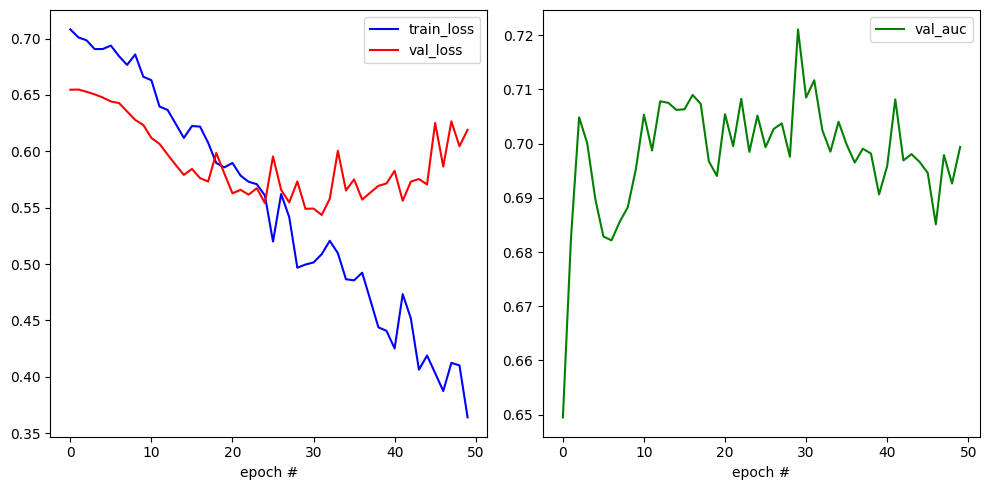


 ############################ CV-Fold 1 - Balanced training ############################

Init loss function... Done!

Init Model... Done!


100%|██████████| 43/43 [00:00<00:00, 110.96it/s]


Init optimizer ... Done!


EPOCH:   0    Train loss: 0.708    Val loss: 0.656    ROC_AUC: 0.599    Max AUC: 0.5991  -    AUC_1: 0.747  AUC_2: 0.537  AUC_3: 0.513
EPOCH:   1    Train loss: 0.703    Val loss: 0.657    ROC_AUC: 0.581    Max AUC: 0.5991  -    AUC_1: 0.719  AUC_2: 0.539  AUC_3: 0.484
EPOCH:   2    Train loss: 0.697    Val loss: 0.656    ROC_AUC: 0.615    Max AUC: 0.6151  -    AUC_1: 0.707  AUC_2: 0.635  AUC_3: 0.503
EPOCH:   3    Train loss: 0.698    Val loss: 0.655    ROC_AUC: 0.599    Max AUC: 0.6151  -    AUC_1: 0.724  AUC_2: 0.572  AUC_3: 0.500
EPOCH:   4    Train loss: 0.694    Val loss: 0.658    ROC_AUC: 0.600    Max AUC: 0.6151  -    AUC_1: 0.696  AUC_2: 0.609  AUC_3: 0.497
EPOCH:   5    Train loss: 0.694    Val loss: 0.656    ROC_AUC: 0.607    Max AUC: 0.6151  -    AUC_1: 0.702  AUC_2: 0.607  AUC_3: 0.513
EPOCH:   6    Train loss: 0.681    Val loss: 0.656    ROC_AUC: 0.623    Max AUC: 0.6231  -    AUC_1: 0.716  AUC_2: 0.624  AUC_3: 0.529
EPOCH:   7    Train loss: 0.676    Val loss: 0.654    R

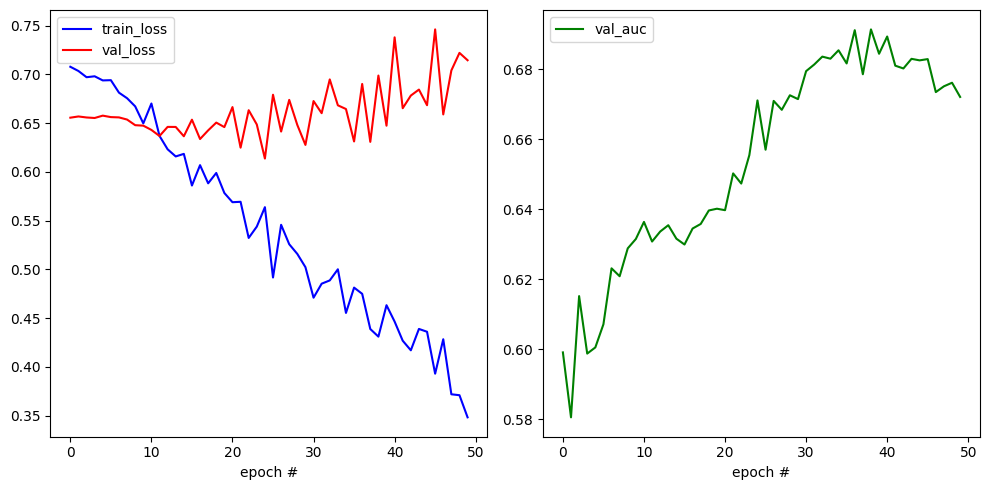


 ############################ CV-Fold 2 - Balanced training ############################

Init loss function... Done!

Init Model... Done!


100%|██████████| 43/43 [00:00<00:00, 118.61it/s]


Init optimizer ... Done!


EPOCH:   0    Train loss: 0.707    Val loss: 0.668    ROC_AUC: 0.530    Max AUC: 0.5301  -    AUC_1: 0.672  AUC_2: 0.461  AUC_3: 0.458
EPOCH:   1    Train loss: 0.705    Val loss: 0.668    ROC_AUC: 0.613    Max AUC: 0.6131  -    AUC_1: 0.721  AUC_2: 0.639  AUC_3: 0.480
EPOCH:   2    Train loss: 0.696    Val loss: 0.667    ROC_AUC: 0.616    Max AUC: 0.6164  -    AUC_1: 0.728  AUC_2: 0.641  AUC_3: 0.480
EPOCH:   3    Train loss: 0.692    Val loss: 0.666    ROC_AUC: 0.613    Max AUC: 0.6164  -    AUC_1: 0.713  AUC_2: 0.658  AUC_3: 0.467
EPOCH:   4    Train loss: 0.693    Val loss: 0.665    ROC_AUC: 0.615    Max AUC: 0.6164  -    AUC_1: 0.703  AUC_2: 0.660  AUC_3: 0.484
EPOCH:   5    Train loss: 0.696    Val loss: 0.664    ROC_AUC: 0.629    Max AUC: 0.6285  -    AUC_1: 0.710  AUC_2: 0.682  AUC_3: 0.493
EPOCH:   6    Train loss: 0.679    Val loss: 0.660    ROC_AUC: 0.634    Max AUC: 0.6338  -    AUC_1: 0.708  AUC_2: 0.684  AUC_3: 0.510
EPOCH:   7    Train loss: 0.677    Val loss: 0.659    R

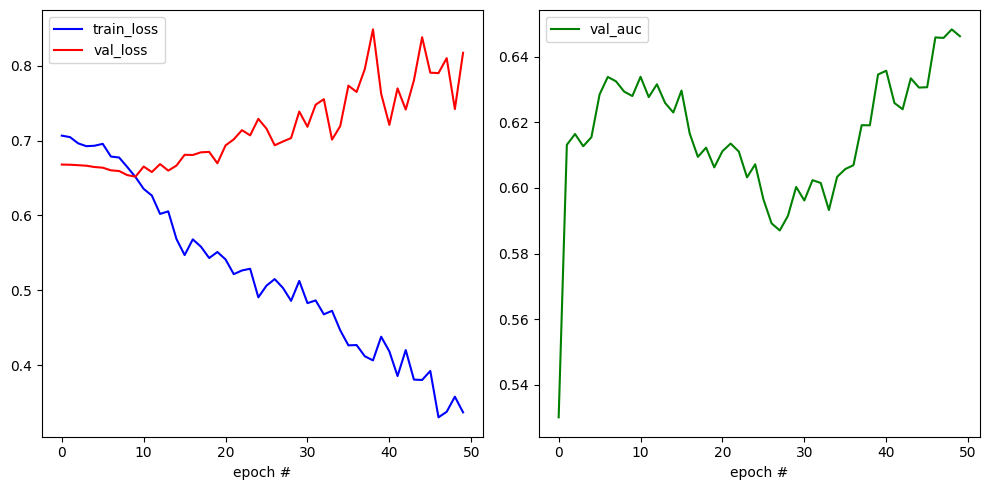


 ############################ CV-Fold 3 - Balanced training ############################

Init loss function... Done!

Init Model... Done!


100%|██████████| 43/43 [00:00<00:00, 145.18it/s]



Init optimizer ... Done!
EPOCH:   0    Train loss: 0.700    Val loss: 0.667    ROC_AUC: 0.630    Max AUC: 0.6303  -    AUC_1: 0.782  AUC_2: 0.511  AUC_3: 0.598
EPOCH:   1    Train loss: 0.702    Val loss: 0.666    ROC_AUC: 0.620    Max AUC: 0.6303  -    AUC_1: 0.746  AUC_2: 0.561  AUC_3: 0.552
EPOCH:   2    Train loss: 0.702    Val loss: 0.666    ROC_AUC: 0.611    Max AUC: 0.6303  -    AUC_1: 0.744  AUC_2: 0.530  AUC_3: 0.559
EPOCH:   3    Train loss: 0.698    Val loss: 0.665    ROC_AUC: 0.616    Max AUC: 0.6303  -    AUC_1: 0.731  AUC_2: 0.558  AUC_3: 0.559
EPOCH:   4    Train loss: 0.697    Val loss: 0.664    ROC_AUC: 0.615    Max AUC: 0.6303  -    AUC_1: 0.728  AUC_2: 0.554  AUC_3: 0.562
EPOCH:   5    Train loss: 0.696    Val loss: 0.661    ROC_AUC: 0.628    Max AUC: 0.6303  -    AUC_1: 0.726  AUC_2: 0.608  AUC_3: 0.549
EPOCH:   6    Train loss: 0.692    Val loss: 0.658    ROC_AUC: 0.643    Max AUC: 0.6429  -    AUC_1: 0.733  AUC_2: 0.630  AUC_3: 0.565
EPOCH:   7    Train loss: 0.6

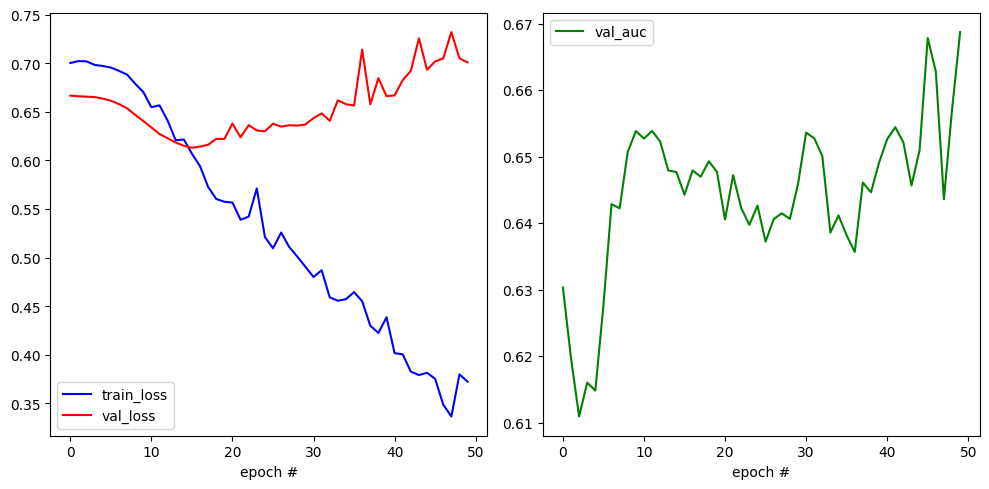


 ############################ CV-Fold 4 - Balanced training ############################

Init loss function... Done!

Init Model... Done!


100%|██████████| 42/42 [00:00<00:00, 121.69it/s]


Init optimizer ... Done!


EPOCH:   0    Train loss: 0.708    Val loss: 0.660    ROC_AUC: 0.693    Max AUC: 0.6933  -    AUC_1: 0.798  AUC_2: 0.565  AUC_3: 0.717
EPOCH:   1    Train loss: 0.699    Val loss: 0.659    ROC_AUC: 0.748    Max AUC: 0.7477  -    AUC_1: 0.851  AUC_2: 0.642  AUC_3: 0.750
EPOCH:   2    Train loss: 0.700    Val loss: 0.658    ROC_AUC: 0.730    Max AUC: 0.7477  -    AUC_1: 0.844  AUC_2: 0.630  AUC_3: 0.717
EPOCH:   3    Train loss: 0.694    Val loss: 0.656    ROC_AUC: 0.738    Max AUC: 0.7477  -    AUC_1: 0.865  AUC_2: 0.633  AUC_3: 0.717
EPOCH:   4    Train loss: 0.697    Val loss: 0.653    ROC_AUC: 0.731    Max AUC: 0.7477  -    AUC_1: 0.862  AUC_2: 0.617  AUC_3: 0.713
EPOCH:   5    Train loss: 0.697    Val loss: 0.651    ROC_AUC: 0.732    Max AUC: 0.7477  -    AUC_1: 0.870  AUC_2: 0.617  AUC_3: 0.710
EPOCH:   6    Train loss: 0.687    Val loss: 0.644    ROC_AUC: 0.739    Max AUC: 0.7477  -    AUC_1: 0.865  AUC_2: 0.644  AUC_3: 0.710
EPOCH:   7    Train loss: 0.682    Val loss: 0.640    R

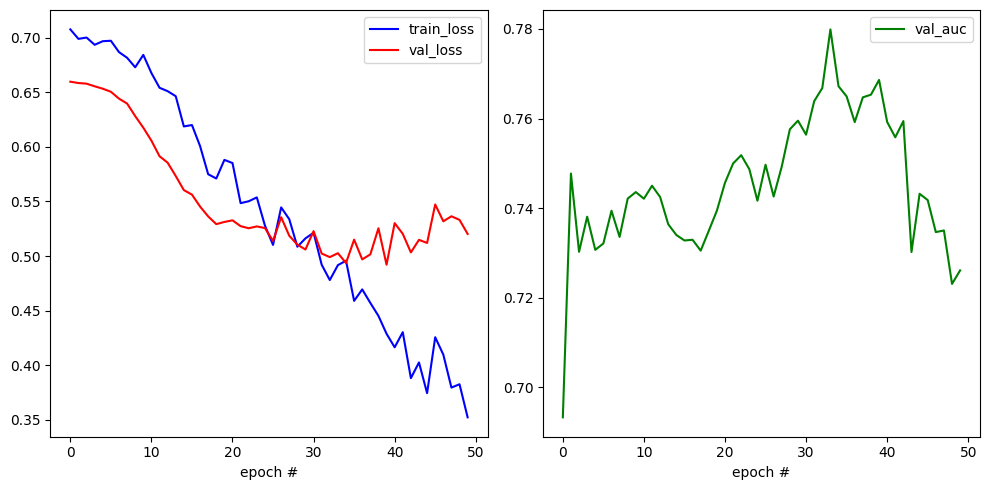

Max AUC in folds:  [np.float64(0.7210678210678211), np.float64(0.6913387390529335), np.float64(0.6483081188963542), np.float64(0.6687325746149276), np.float64(0.7799013283474311)]
Mean AUC:  0.7018697163958935


In [20]:
for n_experiment in range(conf_train.n_experiment):

    print('\n')
    print('\n')
    print(f'##################################################################')
    print(f'###################### RUN - {n_experiment} ######################')
    print(f'##################################################################')
    print('\n')
    print('\n')
    max_val_aucs_all_epoch = []

    for i in range(5):

        print(f'\n ############################ CV-Fold {i} - Balanced training ############################')
        seed_torch(n_experiment)

        print('\nInit loss function...', end=' ')
        #loss_fn = nn.CrossEntropyLoss()

        # Use focal loss
        loss_fn = FocalLoss(gamma=1.0, alpha=alpha_sqrt_inv)
        
        print('Done!')

        print('\nInit Model...', end=' ')
        device = torch.device(f'cuda:{CUDA_NUM}' if torch.cuda.is_available() else 'cpu')
        model = Feature_attention( conf_train.emb_dim, 
                                   conf_train.hidden_dim, 
                                   conf_train.att_hidden_dim,
                                   conf_train.dropout_fc,
                                   conf_train.dropout_attn, 
                                   conf_train.n_classes).to(device)
        print('Done!')

        train_df = pd.read_csv(f'{conf_train["cv_split_dir"]}train_split_multi_stratified_{i}.csv')
        val_df = pd.read_csv(f'{conf_train["cv_split_dir"]}val_split_multi_stratified_{i}.csv')

        X_train_all, y_train_all = read_cv_data(train_df)
        X_val_all, y_val_all = read_cv_data(val_df)
        
        #print(np.unique(y_train_all))
        #print(np.unique(y_val_all))

        results_dir = conf_train.results_dir + f'experiment_{n_experiment}/'
        #print("Results dir: ", results_dir)
        os.makedirs(results_dir, exist_ok=True)
        OmegaConf.save(config=OmegaConf.create(conf_train), f=results_dir+"conf_train.yaml")

        num_epochs = conf_train.num_epochs
        batch_size = conf_train.batch_size
        n_classes = conf_train.n_classes
        
        param_dict = train_loop(i, X_train_all, y_train_all, X_val_all, y_val_all, 
                                results_dir, num_epochs, model, n_classes, loss_fn, gc=32)
        
        max_val_aucs_all_epoch.append( np.max(param_dict['val_auc_all_epoch']) )


        json_data = {'num_epochs': param_dict['num_epochs'],
                     'train_loss_all_epoch_cv': param_dict['train_loss_all_epoch'],
                     'val_loss_all_epoch_all_cv': param_dict['val_loss_all_epoch'],
                     'val_auc_all_epoch_all_cv': param_dict['val_auc_all_epoch'],
                     'min_val_loss': np.min(param_dict['val_loss_all_epoch']),
                     'max_val_auc': np.max(param_dict['val_auc_all_epoch'])}

        # Save training parameters to disk    
        with open(results_dir + f"cv_{i}/" 'test_params.json', 'w') as file:
            json.dump(json_data, file)

        """    
        # plot curves
        plt.figure(figsize=(6,6))
        plt.plot(json_data['train_loss_all_epoch_cv'], "-b", label="train_loss")
        plt.plot(json_data['val_loss_all_epoch_all_cv'], "-r", label="val_loss")
        plt.legend(loc="upper right")

        plt.figure(figsize=(6,6))
        plt.plot(json_data['val_auc_all_epoch_all_cv'], "-g", label="val_auc")
        plt.legend(loc="upper right")
        """
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        ax1.plot(json_data['train_loss_all_epoch_cv'], "-b", label="train_loss")
        ax1.plot(json_data['val_loss_all_epoch_all_cv'], "-r", label="val_loss")
        ax1.set_xlabel('epoch #')
        ax1.legend()

        ax2.plot(json_data['val_auc_all_epoch_all_cv'], "-g", label="val_auc")
        ax2.set_xlabel('epoch #')
        ax2.legend()

        plt.tight_layout()
        plt.show()
        
        
        # free memory !
        del X_train_all, y_train_all, X_val_all, y_val_all

    print('Max AUC in folds: ', max_val_aucs_all_epoch)
    print('Mean AUC: ', np.mean(max_val_aucs_all_epoch))

In [21]:
max_val_aucs_all_epoch

[np.float64(0.7210678210678211),
 np.float64(0.6913387390529335),
 np.float64(0.6483081188963542),
 np.float64(0.6687325746149276),
 np.float64(0.7799013283474311)]

In [22]:
np.mean(max_val_aucs_all_epoch)

np.float64(0.7018697163958935)